In [7]:
import numpy as np
import tensorflow as tf
import utils
from tictactoegame import TicTacToe as Board
from tictactoegame import Player
from tictactoegame import RandomMoves
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os

In [ ]:
# currently, the data generation strategy is inefficient since everything is going to be re-evaluated during the forward pass.

In [8]:
class Agent(Player):
    def __init__(self,c,policy=None):
        if policy is None:
            policy = tf.keras.Sequential([tf.keras.layers.Dense(64,activation='relu') for i in range(2)]+
                                        [tf.keras.layers.Dense(9,activation='softmax')])
        super().__init__(c)
        self.policy = policy # <-- policy is a Keras model taking 3x3 array to 1x9 array of probabilities
        self.policy.build((None,18))
    
    @tf.function
    def __call__(self, st): # <-- st has shape (batch, 18)
        return self.policy(st)
    
    def makeMove(self, board):
        actions = self.getAvailPosn(board)
        if len(actions)==0:
            return False
        st = utils.board_to_features(board.board)
        st = st.T
        pA = tf.squeeze(self.policy(st))
        action = np.random.choice(9, p=pA.numpy())
        coord = divmod(action,3)
        if board.board[coord[0],coord[1]] != 0: 
            board.board[coord[0],coord[1]]=9
            return action
        board.setPiece(coord, self.c)
        return action

class Session():
    def __init__(self,X=None,O=None,lr=1e-3,gamma=0.8):
        self.lr=lr
        self.gamma=gamma
        self.discount=tf.constant([gamma**(gamma-t-1) for t in range(8)],dtype=tf.float32)
        self.Xs = X if X is not None else RandomMoves(1)
        self.Os = O if O is not None else RandomMoves(-1)
        self.board = Board()
        self.opt=tf.keras.optimizers.Adam(-1*lr)
        self.hasGenerator=False
        self.hasDataset=False
        
    def get_data_gen(self):
        if self.hasGenerator==True:
            return self.data_gen
        def data_generator():
            while True:
                S,A=[],[]
                for st,at in self:
                    S.append(st)
                    A.append(at)
                S=tf.concat(S,axis=0)
                A=tf.stack(A,axis=0)
                yield (S,A),self.get_reward()
        self.data_gen=data_generator
        self.hasGenerator=True
        return self.data_gen
    
    def getDataset(self):
        if self.hasDataset==True:
            return self.dataset
        self.dataset=tf.data.Dataset.from_generator(self.get_data_gen(),output_signature=((tf.TensorSpec(shape=[None,18],dtype=tf.int32),
                                                                        tf.TensorSpec(shape=[None],dtype=tf.int32)),tf.TensorSpec(shape=None)))
        self.hasDataset=True
        return self.dataset
    
    @tf.function
    def get_pg(self,S,A,r,discount):
        A = tf.one_hot(A,depth=9)
        idxs = tf.where(A)
        V = discount*r
        with tf.GradientTape() as tape:
            P = self.Xs(S)
            P = tf.gather_nd(P,idxs)
            logP = tf.math.log(P)
            logP = tf.reduce_sum(logP*V)
        grads = tape.gradient(logP, self.Xs.policy.variables)
        return grads
    
    def train_step(self,batch_size=10):
        R=tf.constant([0.0])
        aveG=[]
        for (S,A),r in self.getDataset().take(batch_size):
            length=tf.shape(S)[0]
            grads=self.get_pg(S,A,r,self.discount[:length])
            if len(aveG) == 0:
                aveG = grads
            else:
                for i in range(len(grads)):   # <-- for computing expected policy gradient
                    aveG[i] += grads[i]
            R=tf.concat([R,r[tf.newaxis]],axis=0)
        aveG=[grad / batch_size for grad in aveG]
        self.opt.apply_gradients(list(zip(aveG,self.Xs.policy.variables)))
        return tf.reduce_mean(R[1:])
    
    def train_loop(self,epochs,batch_size):
        epoch=0
        aveR=[]
        while epoch < epochs:
            print(epoch)
            clear_output(wait=True)
            aveR.append(self.train_step(batch_size))
            epoch+=1
        return aveR
        
    def get_reward(self):
        if self.board.isGameOver(1):
            return 1
        if self.board.isGameOver(-1):
            return -1
        if 9 in self.board.board:
            return -1
        if len(self.board.getPosns(0))==0:
            return 0
        return 0
        
    def __iter__(self): # <-- only record Xs moves, for now.
        self.board.reset()
        return self
    
    def __next__(self):
        if self.board.isGameOver(1) or self.board.isGameOver(-1):
            raise StopIteration
        if len(self.board.getPosns(9))!=0:
            raise StopIteration
        elif len(self.board.getPosns(0)) == 0:
            raise StopIteration
        else:
            st,at = utils.board_to_features(self.board.board).T, self.Xs.makeMove(self.board)
            if self.board.isGameOver(1) or len(self.board.getPosns(9))!=0:
                return st,at
            self.Os.makeMove(self.board)
            return st,at

In [9]:
sess=Session(X=Agent(1))

In [10]:
aveR=sess.train_loop(100,15)

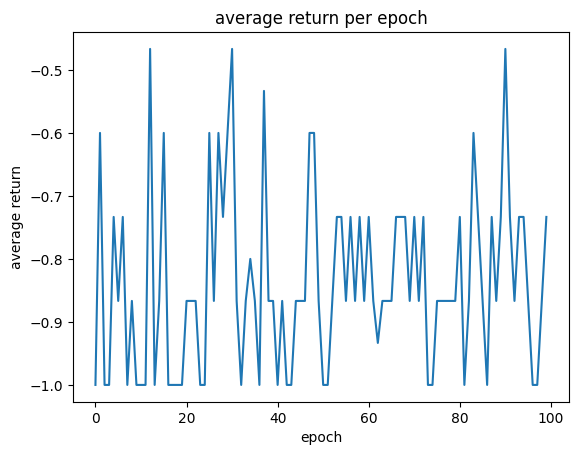

In [15]:
plt.plot(aveR)
plt.title('average return per epoch')
plt.ylabel('average return')
plt.xlabel('epoch')
plt.show()

In [24]:
wins=0
losses=0
draws=0
for (S,A),r in sess.dataset.take(100):
    if r==1:
        wins+=1
    elif r==-1:
        losses+=1
    else:
        draw+=1

print(wins/100,losses/100,draws/100)

0.07 0.93 0.0


In [28]:
for i in sess:
    print(sess.board.board)

[[ 0  0  0]
 [ 1  0  0]
 [-1  0  0]]
[[ 1  0 -1]
 [ 1  0  0]
 [-1  0  0]]
[[ 9  0 -1]
 [ 1  0  0]
 [-1  0  0]]


In [91]:
sess.Xs.policy.save_weights('./X_weights')

In [29]:
P0=sess.Xs.policy(np.zeros((1,18)))

In [30]:
P0=tf.reshape(P0,(3,3))

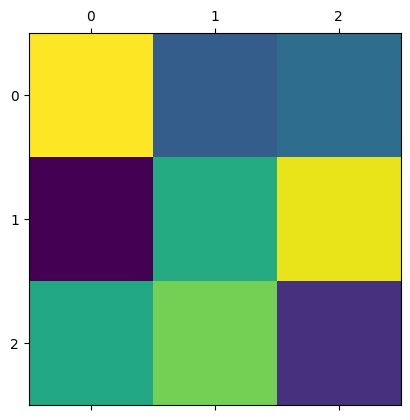

In [31]:
plt.matshow(P0)